## Grovers algorithm for 4 qubits
#### marked state 0010
##### see also http://www.diva-portal.org/smash/get/diva2:1214481/FULLTEXT01.pdf

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

from qiskit.circuit import Parameter
from math import pi as pi

In [2]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 3):
        raise ValueError('The controlled Z with more than 3 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
    elif (len(controls) == 3):
        circuit.cu1(pi/4, controls[0], target)
        circuit.cx(controls[0], controls[1])
        circuit.cu1(-pi/4, controls[1],target)
        circuit.cx(controls[0], controls[1])
        
        circuit.cu1(pi/4, controls[1], target)
        circuit.cx(controls[1], controls[2])
        circuit.cu1(-pi/4, controls[2], target)
        circuit.cx(controls[0], controls[2])
        
        circuit.cu1(pi/4, controls[2], target)
        circuit.cx(controls[1], controls[2])
        circuit.cu1(-pi/4, controls[2], target)
        circuit.cx(controls[0], controls[2])
        
        circuit.cu1(pi/4, controls[2], target)


In [4]:
def grover_n(circuit, qr, N, barriers = True):
    j = 0
    while j < N:
        
        #####################################
        ### Oracle for 0010

        circuit.x(qr[0])
        circuit.x(qr[2])
        circuit.x(qr[3])

        ######### cccZ #####################
        n_controlled_Z(circuit, [qr[i] for i in range(n-1)], qr[n-1])

        if barriers:
            circuit.barrier()

        circuit.x(qr[0])
        circuit.x(qr[2])
        circuit.x(qr[3])

        if barriers:
            circuit.barrier()
    
        ######################################
        #### Amplification
        circuit.h(qr)
        circuit.x(qr)

        ######## cccZ ###########
        n_controlled_Z(circuit, [qr[i] for i in range(n-1)], qr[n-1])

        if barriers:
            circuit.barrier()

        circuit.x(qr)
        circuit.h(qr)

        if barriers:
            circuit.barrier()
    
        j += 1
        print("I implemented gate M.H.B.H",j,"time.")
        

I implemented gate M.H.B.H 1 time.
I implemented gate M.H.B.H 2 time.
I implemented gate M.H.B.H 3 time.


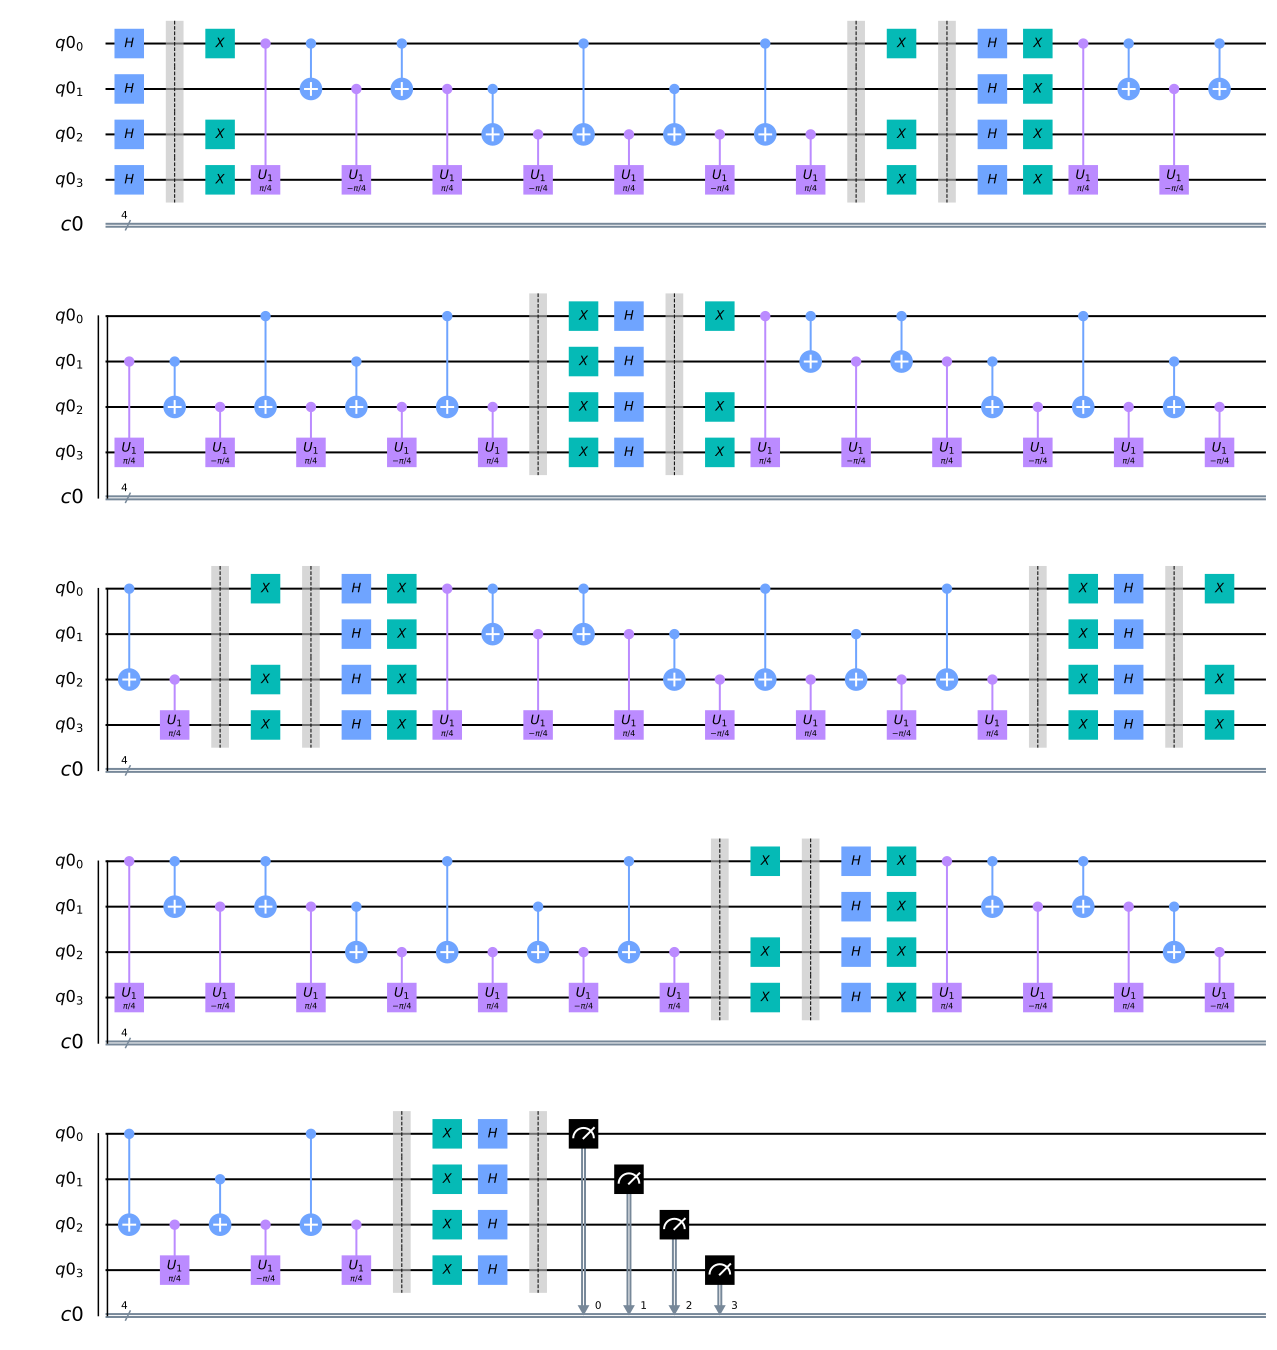

In [5]:
barriers = True
theta = Parameter('θ')

n = 4
qr = QuantumRegister(n)
cr = ClassicalRegister(n)

groverCircuit = QuantumCircuit(qr,cr)
##########################
### Initialization
groverCircuit.h(qr)

if barriers:
    groverCircuit.barrier()
    
#########################
### Grover gate - N times
grover_n(groverCircuit, qr, 3)

#########################
### measure

groverCircuit.measure(qr,cr)
groverCircuit.draw(output="mpl")

## Simulator

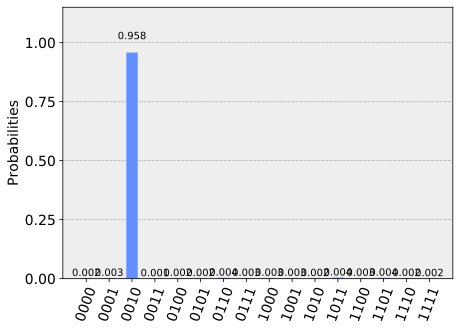

In [6]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2**12
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)


## Device

In [7]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
device = least_busy(provider.backends(simulator=False))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_armonk


In [8]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 4 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_essex


In [9]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 2**12
job = execute(groverCircuit, backend=backend, shots=shots)

job_monitor(job, interval = 2)


Job Status: job has successfully run


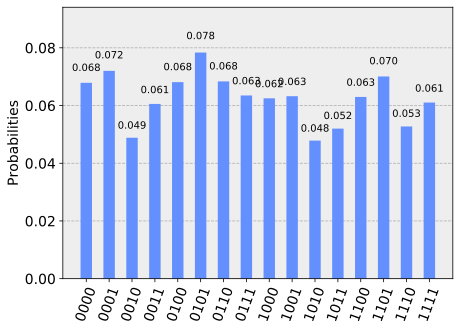

In [10]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(groverCircuit)
plot_histogram(answer)
